In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
import os
import re

In [2]:
train=pd.read_csv("../input/human-protein-atlas-image-classification/train.csv")
train.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [3]:
input_shape = (224, 224, 3)
path_to_train = '../input/human-protein-atlas-image-classification/train/'

In [4]:
train["complete_path"] = path_to_train + train['Id']
train.complete_path[0]
#../input/human-protein-atlas-image-classification/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png

'../input/human-protein-atlas-image-classification/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0'

In [5]:
len(train)

31072

In [6]:
import cv2
from PIL import Image
def load_image(path, shape):
    R = np.array(Image.open(path+'_red.png'))
    G = np.array(Image.open(path+'_green.png'))
    B = np.array(Image.open(path+'_blue.png'))
    Y = np.array(Image.open(path+'_yellow.png'))
    image = np.stack((R,G,(B+Y)/2),-1)
    image = cv2.resize(image, (shape[0], shape[1]))
    image = np.divide(image, 255)
    return image 

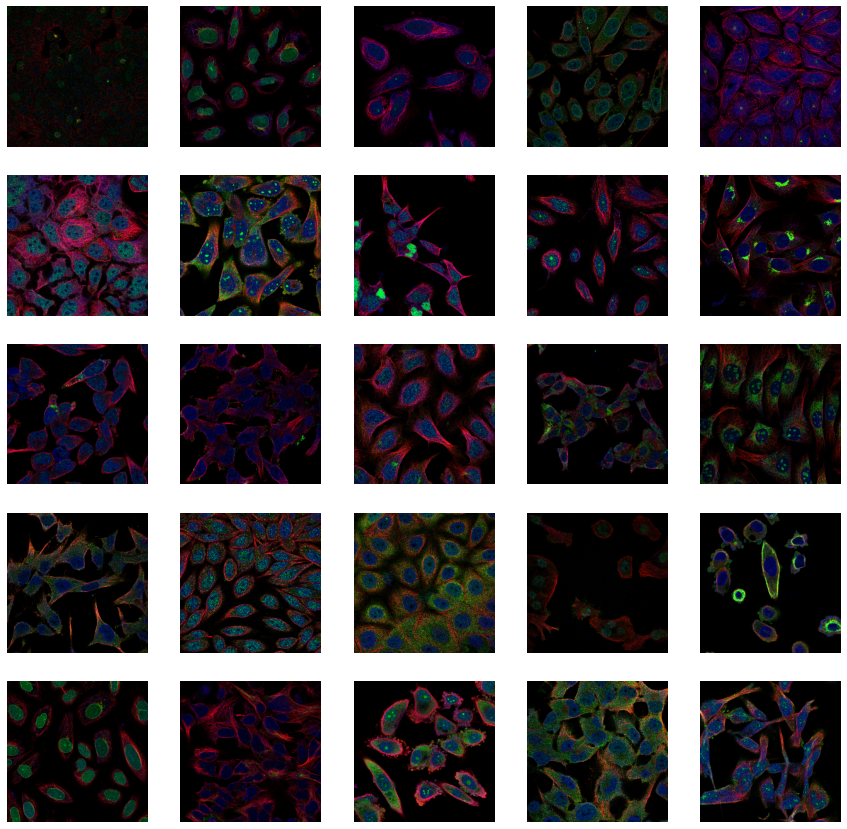

In [7]:
#Display first 25 images
plt.figure(1, figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_image((train.complete_path[i]),input_shape))
    plt.axis('off')
plt.show()

In [8]:
X=[]
y=[]
for i in range(1000):
    image=load_image((train.complete_path[i]),input_shape)
    labels = np.array(train.Target[i].split(" ")).astype(np.int64)
    X.append(image)
    y.append(labels)
    
df=pd.DataFrame({'X':X,
                'y':y})

In [9]:
df.head(5)

,X,y
0,"[[[0.008503401360544218, 0.04501800720288115, ...","[16, 0]"
1,"[[[0.06726690676270507, 0.002300920368147259, ...","[7, 1, 2, 0]"
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",[5]
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0003001...",[1]
4,"[[[0.0, 0.0, 0.0008103241296518606], [0.0, 0.0...",[18]


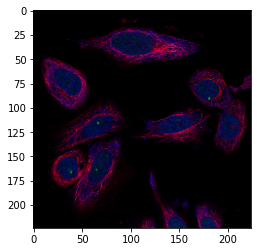

In [10]:
from tensorflow.keras.preprocessing import image
plt.imshow(X[2])

In [11]:
X=np.array(X)

In [12]:
X.shape #1000 images, 224 width and height, 3 channels

(1000, 224, 224, 3)

In [13]:
labels = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

rd=dict((v,k) for k,v in labels.items())

# reversed_dictionary = {value : key for (key, value) in labels.items()}

def targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = labels[int(num)]
        row.loc[name] = 1
    return row

In [14]:
for key in labels.keys():
    train[labels[key]] = 0

In [15]:
train = train.apply(targets, axis=1)

In [16]:
c=train.drop(["Id","Target","complete_path"],axis=1)

In [17]:
c.head(5)

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [18]:
c=c.iloc[:1000]

In [19]:
c.columns

Index(['Nucleoplasm', 'Nuclear membrane', 'Nucleoli',
       'Nucleoli fibrillar center', 'Nuclear speckles', 'Nuclear bodies',
       'Endoplasmic reticulum', 'Golgi apparatus', 'Peroxisomes', 'Endosomes',
       'Lysosomes', 'Intermediate filaments', 'Actin filaments',
       'Focal adhesion sites', 'Microtubules', 'Microtubule ends',
       'Cytokinetic bridge', 'Mitotic spindle',
       'Microtubule organizing center', 'Centrosome', 'Lipid droplets',
       'Plasma membrane', 'Cell junctions', 'Mitochondria', 'Aggresome',
       'Cytosol', 'Cytoplasmic bodies', 'Rods & rings'],
      dtype='object')

In [20]:
c.shape

(1000, 28)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,c,test_size=0.3,random_state=42)

In [22]:
y_test.shape, y_train.shape, X_test.shape, X_train.shape

((300, 28), (700, 28), (300, 224, 224, 3), (700, 224, 224, 3))

In [23]:
def create_model(input_shape):
    model = Sequential()
    model.add(tensorflow.keras.applications.InceptionResNetV2(include_top=False, pooling='avg', input_shape=input_shape, weights="imagenet"))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.8))
    model.add(Dense(28, activation='sigmoid'))
    return model

input_shape= (224,224,3)
model = create_model(input_shape)
model.summary()

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# history = model.fit(train_data_batches, steps_per_epoch = 150, validation_data = val_data_batches, epochs=10)
epochs=10
H = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=32)

2021-11-21 09:48:26.903372: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
22/22 [==============================] - 304s 13s/step - loss: 0.3329 - accuracy: 0.1600 - val_loss: 131.3905 - val_accuracy: 0.3900
Epoch 2/10
22/22 [==============================] - 274s 13s/step - loss: 0.2261 - accuracy: 0.2429 - val_loss: 4.6174 - val_accuracy: 0.3933
Epoch 3/10
22/22 [==============================] - 273s 12s/step - loss: 0.2085 - accuracy: 0.3043 - val_loss: 0.5657 - val_accuracy: 0.3933
Epoch 4/10
22/22 [==============================] - 274s 13s/step - loss: 0.1986 - accuracy: 0.3414 - val_loss: 0.5963 - val_accuracy: 0.1167
Epoch 5/10
22/22 [==============================] - 273s 12s/step - loss: 0.1806 - accuracy: 0.3757 - val_loss: 0.6242 - val_accuracy: 0.0500
Epoch 6/10
22/22 [==============================] - 271s 12s/step - loss: 0.1747 - accuracy: 0.4014 - val_loss: 1.5039 - val_accuracy: 0.3800
Epoch 7/10
22/22 [==============================] - 272s 12s/step - loss: 0.1731 - accuracy: 0.3800 - val_loss: 0.2378 - val_accuracy: 0.1700
Epoc

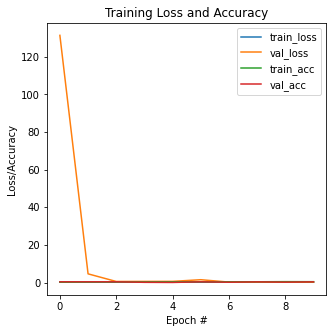

In [27]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

[16  0](0.7705507278442383)
[11](0.2957066595554352)
[16  6](0.16217529773712158)
[25  0](0.14943403005599976)
[0](0.08407610654830933)
[5](0.07020959258079529)
[0](0.017842739820480347)
[7 1 2 0](0.017709553241729736)
[0](0.017037421464920044)
[21](0.012330591678619385)
[25 11](0.0110701322555542)
[1](0.009741544723510742)
[25  2](0.008148133754730225)
[18](0.006638139486312866)
[6 2](0.00651860237121582)
[25  2](0.005519121885299683)
[24  0](0.005134254693984985)
[25  0](0.004989355802536011)
[25](0.002063274383544922)
[7 1 2 0](0.0018741190433502197)
[25  3](0.001575380563735962)
[23](0.0014344453811645508)
[23](0.0011501312255859375)
[25  2](0.001045525074005127)
[2 0](0.0008545219898223877)
[7](0.0004672706127166748)
[25](0.000401228666305542)


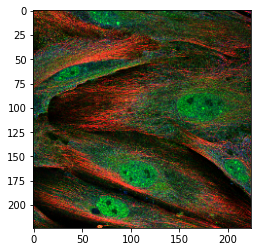

In [28]:
test_path='../input/human-protein-atlas-image-classification/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'
R = np.array(Image.open(test_path+'_red.png'))
G = np.array(Image.open(test_path+'_green.png'))
B = np.array(Image.open(test_path+'_blue.png'))
Y = np.array(Image.open(test_path+'_yellow.png'))
image = np.stack((
            R,
            G, 
            (B+Y)/2),-1)
image = cv2.resize(image, (224, 224))
#img = image.img_to_array(img)
img = image/255.0
classes = df.y
proba = model.predict(img.reshape(1,224,224,3))
top = np.argsort(proba[0])[::-1]
for i in range(27):
    print("{}".format(classes[top[i]])+ "({})".format(proba[0][top[i]]))
    y=classes[top[0]]
plt.imshow(img)

Nucleoplasm(0.3758830428123474)
Nuclear bodies(0.14686104655265808)
Nucleoli fibrillar center(0.1456603705883026)
Nuclear speckles(0.13850152492523193)
Golgi apparatus(0.11316901445388794)
Cytosol(0.10779884457588196)
Nuclear membrane(0.08981654047966003)
Nucleoli(0.07388001680374146)
Microtubule organizing center(0.07211002707481384)
Mitochondria(0.07183152437210083)
Centrosome(0.06965100765228271)
Intermediate filaments(0.055688828229904175)
Plasma membrane(0.051737189292907715)
Endoplasmic reticulum(0.031246602535247803)
Mitotic spindle(0.024850696325302124)
Cytokinetic bridge(0.024148672819137573)
Cell junctions(0.017431527376174927)
Focal adhesion sites(0.01530727744102478)
Microtubules(0.014630377292633057)
Actin filaments(0.013199776411056519)
Aggresome(0.012885987758636475)
Cytoplasmic bodies(0.011424481868743896)
Lipid droplets(0.011413753032684326)
Rods & rings(0.009449809789657593)
Peroxisomes(0.005779683589935303)
Endosomes(0.005779623985290527)
Microtubule ends(0.005479931

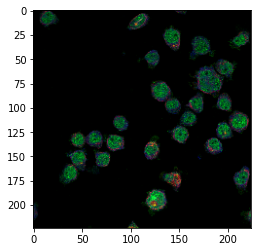

In [29]:
path='../input/human-protein-atlas-image-classification/test/00ad3e84-bad1-11e8-b2b8-ac1f6b6435d0'
R = np.array(Image.open(path+'_red.png'))
G = np.array(Image.open(path+'_green.png'))
B = np.array(Image.open(path+'_blue.png'))
Y = np.array(Image.open(path+'_yellow.png'))
image = np.stack((
            R,
            G, 
            (B+Y)/2),-1)
image = cv2.resize(image, (224, 224))
#img = image.img_to_array(img)
img = image/255.0
classes = c.columns
proba = model.predict(img.reshape(1,224,224,3))
top = np.argsort(proba[0])[::-1]
for i in range(27):
    print("{}".format(classes[top[i]])+ "({})".format(proba[0][top[i]]))
plt.imshow(img)

In [30]:
submission=pd.read_csv("../input/human-protein-atlas-image-classification/sample_submission.csv")
submission.head(5)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [31]:
submission.shape

(11702, 2)

In [32]:
submission=submission.iloc[:10]

In [33]:
submission.shape

(10, 2)

In [34]:
path_to_test ='../input/human-protein-atlas-image-classification/test/'
for i in range(10):
    submission["complete_path"] = path_to_test + submission['Id']
submission.head(5)

,Id,Predicted,complete_path
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0,../input/human-protein-atlas-image-classificat...
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0,../input/human-protein-atlas-image-classificat...
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0,../input/human-protein-atlas-image-classificat...
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0,../input/human-protein-atlas-image-classificat...
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0,../input/human-protein-atlas-image-classificat...


In [35]:
X=[]
for i in range(10):
    image=load_image((submission.complete_path[i]),input_shape)
    X.append(image)

In [36]:
X=np.array(X)

In [37]:
X.shape

(10, 224, 224, 3)

In [38]:
classes = c.columns
predicted=[]
for i in range(10):
    proba = model.predict(X[i].reshape(1,224,224,3))
    top = np.argsort(proba[0])[::-1]       
    predicted.append(str(rd[classes[top[0]]]) +' '+ str(rd[classes[top[1]]]) +' '+ str(rd[classes[top[2]]]))

In [39]:
s=pd.DataFrame({'Id':submission.Id,'predicted': predicted})

In [40]:
s.head()

,Id,predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2 0 3
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,23 7 5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 2 23
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25 23
